# Crash Course in Causality

Name: Kiran Gowda Ramanagara Jayaram

NUID: 002330668




## Abstract

In this notebook, we dive deep into the world of causal inference using the Titanic dataset as a real-world example. Unlike standard predictive modeling that focuses on associations, our objective is to uncover true cause-and-effect relationships by meticulously preparing the data and applying advanced causal techniques. Readers will learn how to differentiate causation from correlation, properly handle missing data, encode and engineer features, and adjust for confounding factors using propensity score estimation and inverse probability weighting (IPW). We demonstrate how to estimate the causal effect of traveling first class on survival under the potential outcomes framework. Throughout this notebook, extensive theory is paired with detailed, step-by-step code examples, enriched with multiple graphs and thorough explanations that clarify both the methodology and the interpretation of results.

Furthermore, we explore the practical challenges encountered in causal inference, such as model selection, bias reduction, and sensitivity analysis, and provide comprehensive strategies to address these issues. Our approach emphasizes the importance of domain knowledge and careful study design when drawing conclusions from observational data. We also discuss common pitfalls and outline best practices that ensure robustness and transparency in our causal analysis. By applying these techniques to the Titanic dataset, users gain valuable insights into how rigorous causal analysis can inform decision-making processes in complex, real-world scenarios. Ultimately, this comprehensive resource is designed to empower data scientists and researchers with the conceptual framework and practical tools necessary to discern true causal relationships amidst noise and confounding influences, leading to more accurate and meaningful inferences in data analysis.


![Titanic Image](https://raw.githubusercontent.com/Masterx-AI/Project_Titanic_Survival_Prediction_/main/titanic.jpg)


# Theory Section

## 1. Understanding Causality vs. Correlation ##

  ## 1.1 What Is Correlation?
Correlation measures the strength and direction of a linear relationship between two variables. For example, you might observe that first-class passengers have a higher survival rate. However, this correlation does not imply that being in first class causes higher survival—there might be other factors (such as age, gender, or socio-economic status) influencing both.

**Graphical Illustration:**  
Imagine a scatter plot where each point represents a passenger. The x-axis shows one variable (e.g., age) and the y-axis shows another (e.g., survival probability). A strong upward trend indicates a correlation, but without further analysis, you cannot say that age causes survival.

  ## 1.2 What Is Causality?
Causality answers the question: *"If I change variable X, how will variable Y change?"* In our context, we ask: *"Does traveling first class increase a passenger’s chance of survival?"*  
For each passenger, there are two potential outcomes:

- **Y(1):** The outcome if the passenger traveled in first class.
- **Y(0):** The outcome if the passenger did not travel in first class.

Since we can observe only one of these for each passenger, we must estimate the causal effect (e.g., the Average Treatment Effect or ATE) by comparing similar groups.

  ## 1.3 Relatable Example
Consider the relationship between outdoor exercise and health. You may find that people who exercise outside are healthier. However, this does not mean that outdoor exercise directly improves health—it might be that people who exercise outdoors also tend to have healthier diets or higher incomes. Therefore, to establish causality, you need to adjust for those confounding factors.

## 2. The Potential Outcomes Framework

This framework posits that for each individual there exist two potential outcomes:

- **\(Y(1)\):** Outcome under treatment (e.g., first-class travel).
- **\(Y(0)\):** Outcome under control (e.g., not first class).

Since we cannot observe both simultaneously, we estimate the average causal effect (ATE) as:

 **ATE=E[Y(1)−Y(0)]**

We use statistical methods to mimic a randomized trial by balancing covariates between groups.

## 3. Data Preprocessing for Causal Inference

  ### 3.1 Handling Missing Data
Missing values, if ignored, can bias our estimates. For example, if Age is missing more often in a certain group, simply omitting those rows might skew our understanding of survival rates. Techniques include imputation (using the median for continuous data) or dropping variables with excessive missingness.

  ### 3.2 Feature Engineering & Selection
Transforming raw data (e.g., encoding categorical variables) ensures that the information is usable by statistical models. This process is essential to accurately estimate relationships and adjust for confounding factors.

  ### 3.3 Adjusting for Confounders
Before estimating causal effects, it is crucial to adjust for variables that affect both the treatment and the outcome. Methods like propensity score estimation help in balancing these confounders so that the comparison between treatment and control groups approximates that of a randomized controlled trial.

## 4. Causal Inference Methods

  ### 4.1 Propensity Score Estimation
Propensity scores represent the probability that an individual receives the treatment given their observed covariates. These scores are typically estimated using logistic regression. When the propensity scores of the treatment and control groups overlap sufficiently, the groups can be balanced, reducing bias.

  ### 4.2 Inverse Probability Weighting (IPW)
IPW uses the inverse of the propensity scores as weights to create a pseudo-population where the treatment assignment is independent of the covariates. By comparing weighted outcomes between groups, we can estimate the causal effect.



![Propensity Score Matching](https://builtin.com/sites/www.builtin.com/files/styles/ckeditor_optimize/public/inline-images/3_propensity-score-matching.jpeg)


![Descriptive Alt Text](https://bigdatarepublic.nl/media/images/features_image_etc..width-500.png)


# Practical Code Examples

Below are detailed code sections split into parts, each followed by an in-depth explanation and multiple graphs.


## Section 1: Data Loading & Initial Exploration


Dataset Preview:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   

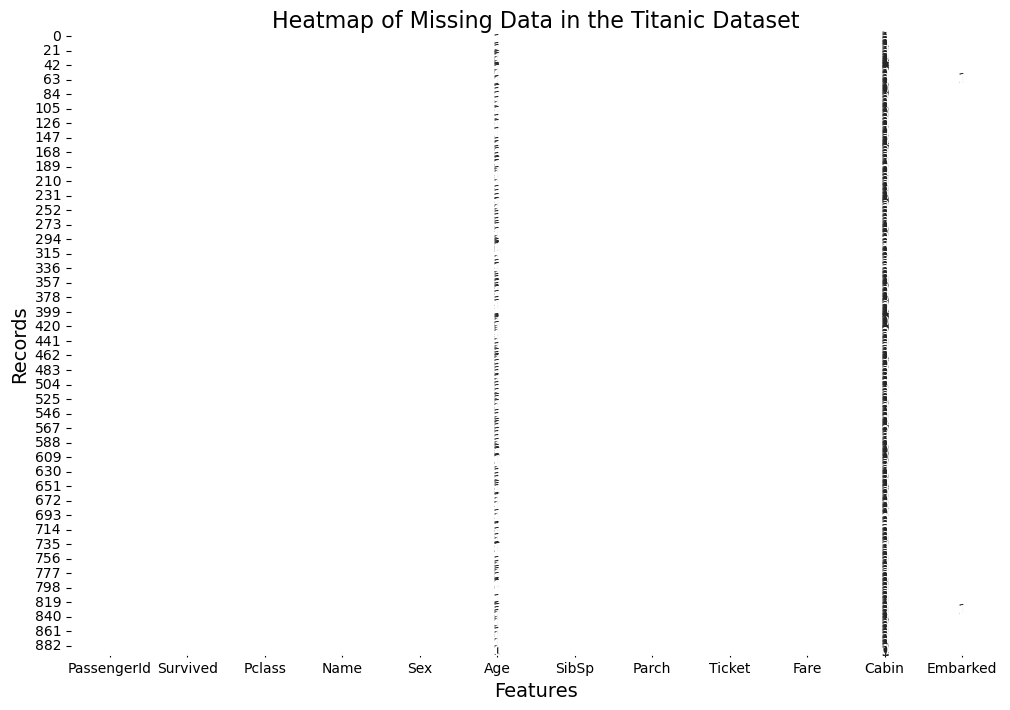

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Titanic dataset from GitHub
titanic_df = pd.read_csv("https://raw.githubusercontent.com/Kiran-Gowda-Ramanagara-Jayaram/TitanicDataset/refs/heads/main/Titanic-Dataset.csv")

# Display a preview of the dataset
print("Dataset Preview:")
print(titanic_df.head())

# Print summary statistics for numerical features
print("\nSummary Statistics:")
print(titanic_df.describe())

# Identify missing values in each column
print("\nMissing Values per Column:")
print(titanic_df.isnull().sum())

# Visualize missing data with a heatmap.
# Here we convert the boolean mask to integers (True -> 1, False -> 0) for clear visualization.
missing_data_int = titanic_df.isnull().astype(int)
plt.figure(figsize=(12, 8))
sns.heatmap(missing_data_int, cbar=False, cmap='viridis', linewidths=0.5, annot=True)
plt.title("Heatmap of Missing Data in the Titanic Dataset", fontsize=16)
plt.xlabel("Features", fontsize=14)
plt.ylabel("Records", fontsize=14)
plt.show()


### Data Loading:
We load the dataset directly from a public GitHub URL, which ensures that the data source is stable and version-controlled.

### Preview & Summary:
The first few rows are printed to get an initial sense of the data. Summary statistics (e.g., mean, standard deviation) help identify distributions and potential outliers.

### Missing Data Analysis:
The command `titanic_df.isnull().sum()` prints the count of missing values per column. The heatmap converts the boolean values into integers (0 for present, 1 for missing), and the annotations let you see exactly where missing values occur.

### Graph Explanation:
The heatmap is color-coded (using the 'viridis' palette) to indicate missing data. Darker cells (with value 1) highlight missing entries, whereas lighter cells (with value 0) show complete data. This visualization is crucial to plan subsequent imputation steps.

## Section 2: Data Cleaning & Preprocessing



Missing Values After Cleaning:
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64


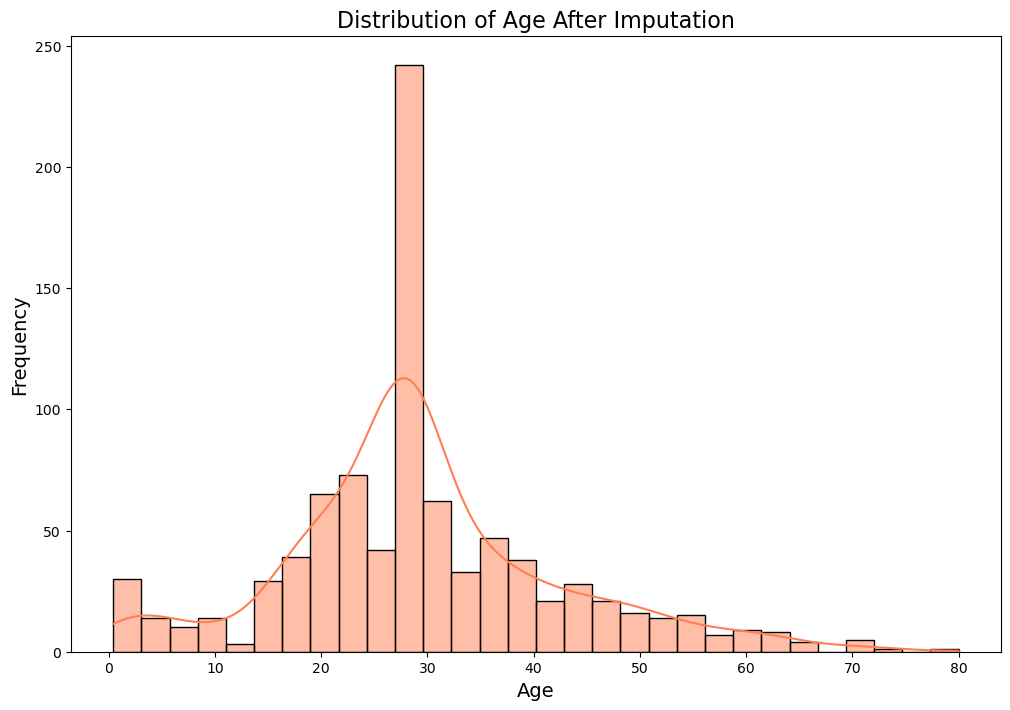


Encoded Dataset Preview:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name   Age  SibSp  Parch  \
0                            Braund, Mr. Owen Harris  22.0      1      0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  38.0      1      0   
2                             Heikkinen, Miss. Laina  26.0      0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  35.0      1      0   
4                           Allen, Mr. William Henry  35.0      0      0   

             Ticket     Fare  Sex_male  Embarked_Q  Embarked_S  
0         A/5 21171   7.2500      True       False        True  
1          PC 17599  71.2833     False       False       False  
2  STON/O2. 3101282   7.9250     False       False        True  
3            113803  53.1000     False  

C:\Users\Kiran Gowda\AppData\Local\Temp\ipykernel_17028\1074453729.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sex_male', data=titanic_df_encoded, palette='muted')


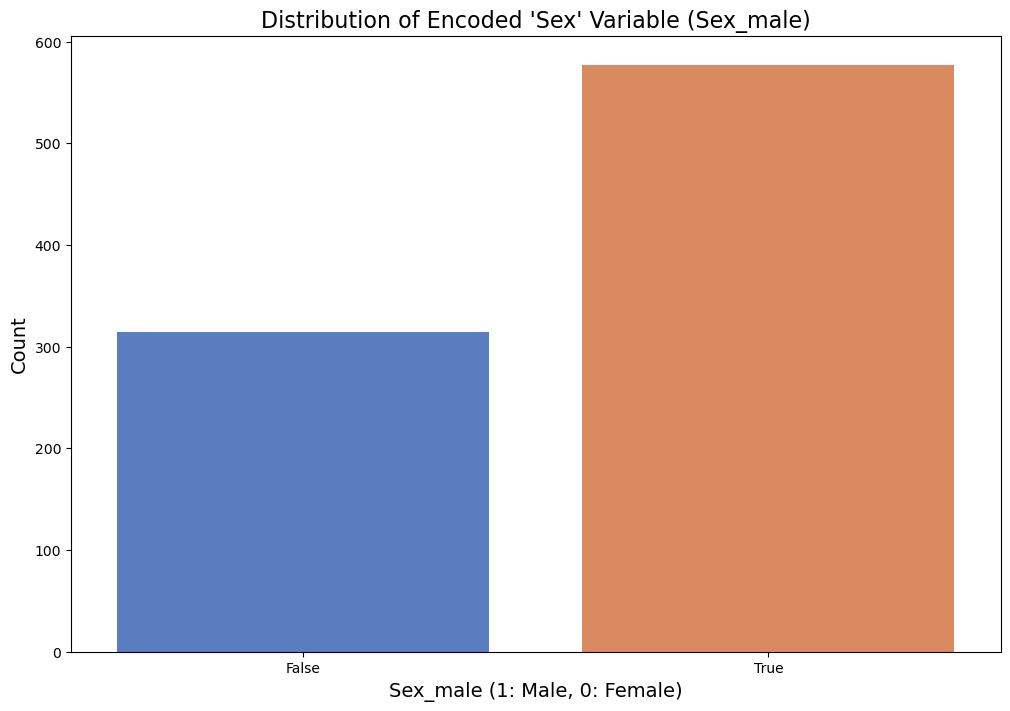

In [3]:
# Impute missing values for 'Age' with the median to avoid bias from extreme values.
titanic_df['Age'] = titanic_df['Age'].fillna(titanic_df['Age'].median())

# Drop the 'Cabin' column because it has too many missing values.
titanic_df.drop(columns=['Cabin'], inplace=True)

# Impute missing values in 'Embarked' with the mode, as it is a categorical variable.
titanic_df['Embarked'] = titanic_df['Embarked'].fillna(titanic_df['Embarked'].mode()[0])

# Confirm that missing values have been addressed.
print("\nMissing Values After Cleaning:")
print(titanic_df.isnull().sum())

# Plot the distribution of Age after imputation to ensure the imputation preserved the original distribution.
plt.figure(figsize=(12, 8))
sns.histplot(titanic_df['Age'], kde=True, bins=30, color='coral')
plt.title("Distribution of Age After Imputation", fontsize=16)
plt.xlabel("Age", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.show()

# Apply one-hot encoding to the categorical columns: 'Sex' and 'Embarked'
titanic_df_encoded = pd.get_dummies(titanic_df, columns=['Sex', 'Embarked'], drop_first=True)

# Display the first few rows of the encoded dataset to verify the changes.
print("\nEncoded Dataset Preview:")
print(titanic_df_encoded.head())

# Visualize the distribution of the encoded 'Sex_male' variable using a count plot.
plt.figure(figsize=(12, 8))
sns.countplot(x='Sex_male', data=titanic_df_encoded, palette='muted')
plt.title("Distribution of Encoded 'Sex' Variable (Sex_male)", fontsize=16)
plt.xlabel("Sex_male (1: Male, 0: Female)", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.show()


### Imputation of Numerical Data (Age Column):

**Replace missing values in the 'Age' column with the median.**

**Rationale:**
- The median is robust to outliers, meaning it is less affected by extreme values.
- This approach preserves the central tendency of the age distribution.

**Impact:**
- Ensures that gaps in the data do not bias analyses that rely on age as an important covariate.


### Dropping Columns with Excessive Missing Data (Cabin Column):

**Remove the 'Cabin' column entirely.**

**Rationale:**
- The 'Cabin' column has an extremely high percentage of missing values.
- Imputing such a column might introduce noise, rather than offering useful insights.

**Impact:**
- Simplifies the dataset by focusing only on variables with reliable and sufficient data.


### Categorical Imputation (Embarked Column):

**Impute missing values in the 'Embarked' column using the mode.**

**Rationale:**
- For categorical data, the mode (most frequent category) is a natural choice.
- This approach preserves the natural frequency distribution of the categories.

**Impact:**
- Maintains the overall integrity of the categorical variable without introducing artificial bias.


### Post-Cleaning Diagnostics:

**Recheck missing value counts after performing imputation and dropping columns.**

**Rationale:**
- Verifying the cleaning process ensures that no missing values remain in critical columns.
- Acts as a quality control step to confirm that data is complete.

**Impact:**
- Provides confidence that the dataset is ready for further analysis.


### Graph Explanation (Histogram with KDE for Age):

**Plot a histogram of the 'Age' column with an overlaid KDE curve.**

**Rationale:**
- The histogram shows the frequency distribution of age values.
- The KDE (Kernel Density Estimate) line smooths out the histogram, highlighting the overall density and any skewness in the distribution.

**Impact:**
- A combined view helps in assessing the distribution shape and verifying that the imputation has preserved the natural pattern of the data.


### One-Hot Encoding & Count Plot:

**Apply one-hot encoding to categorical variables such as 'Sex' and 'Embarked', converting them into binary indicators (e.g., 'Sex_male').**

**Rationale:**
- One-hot encoding transforms non-numeric data into a format that can be used by most machine learning models.
- It preserves the distinct categories by representing them as separate binary columns.

**Verification:**
- A count plot for the newly created binary variable (e.g., 'Sex_male') visually confirms that the distribution of categories (male vs. female) is accurately represented.


## Section 3: Defining the Causal Question and Treatment



Treatment Variable and Covariates:
   Pclass  T  Survived
0       3  0         0
1       1  1         1
2       3  0         1
3       1  1         1
4       3  0         0


C:\Users\Kiran Gowda\AppData\Local\Temp\ipykernel_17028\3406489781.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='T', data=titanic_df_encoded, palette='coolwarm')


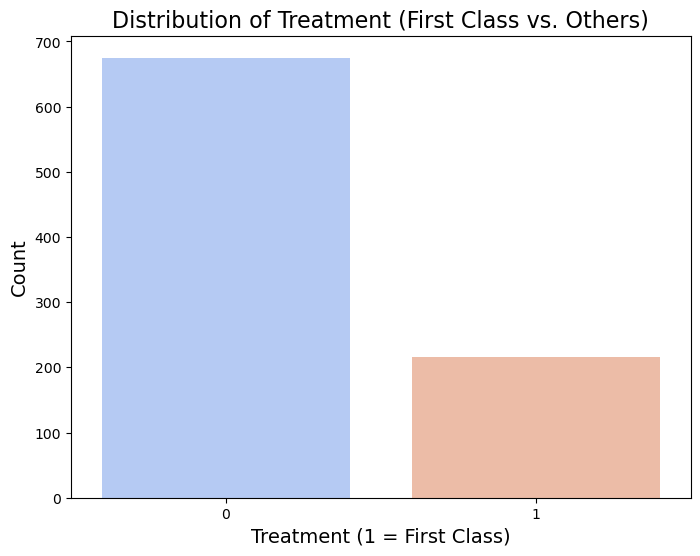

In [4]:
# Define the causal question:
# "Does traveling first class improve a passenger's chance of survival?"
# Create a binary treatment indicator where T=1 if the passenger is in first class, otherwise T=0.
titanic_df_encoded['T'] = np.where(titanic_df_encoded['Pclass'] == 1, 1, 0)

# Our outcome variable is 'Survived'.
# Select covariates that could be confounders (e.g., factors that affect both the likelihood of being in first class and survival).
covariates = ['Age', 'Fare', 'Sex_male', 'Embarked_Q', 'Embarked_S']

# Display a sample of the key columns to verify the treatment indicator.
print("\nTreatment Variable and Covariates:")
print(titanic_df_encoded[['Pclass', 'T', 'Survived']].head())

plt.figure(figsize=(8, 6))
sns.countplot(x='T', data=titanic_df_encoded, palette='coolwarm')
plt.title("Distribution of Treatment (First Class vs. Others)", fontsize=16)
plt.xlabel("Treatment (1 = First Class)", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.show()



# Establishing the Causal Question

We start by asking a critical question: “Does traveling first class improve a passenger's chance of survival?”

This question is central because it focuses on whether there is a direct cause-and-effect relationship between being in first class (the treatment) and survival (the outcome), rather than just a correlation.

## Defining the Treatment Variable

A binary treatment variable is created to clearly distinguish between passengers who traveled in first class and those who did not.

This variable is set so that:
- **1** represents passengers in first class.
- **0** represents passengers in second or third class.

By defining the treatment in this binary manner, we simplify the analysis, enabling us to compare two distinct groups directly.

### Rationale for Treatment Definition

**Clarity and Simplicity:**
- A binary indicator provides a clear division, which is essential when applying causal inference methods such as propensity score estimation or inverse probability weighting.
- This separation helps us conceptualize what the survival outcome would be under two scenarios: one where every passenger is in first class and one where no passenger is in first class.

**Alignment with Potential Outcomes Framework:**
- In the potential outcomes framework, every passenger has two potential outcomes: one if they are treated (first class) and one if they are not (non-first class). Although we cannot observe both for the same individual, defining a clear treatment group helps us estimate the average causal effect.

### Selection of Covariates to Control for Confounding

To isolate the causal effect of first-class travel, we choose a set of covariates that could confound the relationship between treatment and survival. The covariates include factors such as:
- **Age:** Age can influence both the likelihood of surviving (e.g., younger or older passengers might have different survival rates) and possibly the class in which a passenger travels.
- **Fare:** Fare reflects the cost of the ticket and is likely higher for first-class passengers. It may also correlate with survival, as higher fare passengers might receive better services.
- **Encoded Variables for Sex and Embarked:** These variables capture additional demographic and contextual information that might affect both the probability of being in first class and the survival chances.

The inclusion of these covariates helps to balance the comparison between treated and control groups by reducing bias from confounding factors.

### Verifying the Treatment Variable and Covariate Assignment

A quick check of the data confirms that passengers in first class are correctly marked with a treatment value of **1**, while others receive a value of **0**.

This step is crucial to ensure that any subsequent causal inference analysis is based on correctly defined groups.

## Visualization: The Count Plot for Treatment Distribution

A count plot is generated to visually display the distribution of the treatment variable.

**Graph Details:**
- The plot shows two distinct bars:
  - One bar represents passengers with a treatment value of **0** (i.e., those who did not travel first class).
  - The other bar represents passengers with a treatment value of **1** (i.e., those who traveled first class).
- The count plot typically reveals that the bar for **0** is much taller than the bar for **1**. This reflects historical reality: the majority of Titanic passengers were not in first class.

**Interpretation of the Graph:**
- The clear difference in bar heights immediately communicates the imbalance between the groups.
- Recognizing this imbalance is important because it indicates that there are significantly fewer first-class passengers compared to non-first-class ones. This has implications for how precise our causal effect estimates might be and emphasizes the need for robust statistical methods to account for such imbalance.
- The visual confirmation provided by the count plot builds confidence that the treatment variable was correctly defined and that the dataset’s composition aligns with expectations.

## Overall Significance for Causal Analysis

Defining the treatment variable and verifying its distribution through visualizations like the count plot are fundamental steps in causal inference. They ensure that the analysis is structured around a clear and logical comparison between two groups: those exposed to the treatment (first class) and those not.

This structured approach sets the stage for later stages, where techniques like propensity score matching or inverse probability weighting will be applied to adjust for confounders, allowing us to estimate the causal effect of first-class travel on survival.

By understanding the treatment distribution and ensuring covariate balance, we create a robust foundation that mimics the conditions of a randomized experiment as closely as possible, thereby strengthening the validity of our causal conclusions.


## Section 4: Propensity Score Estimation


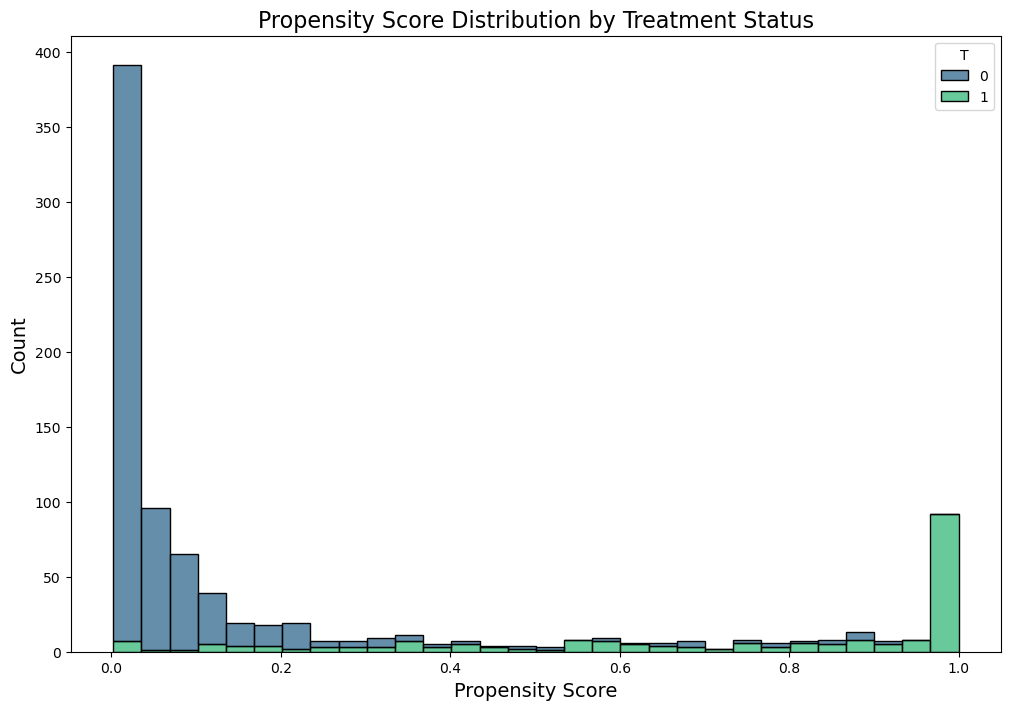

In [5]:
from sklearn.linear_model import LogisticRegression

# Estimate the propensity score, which is the probability of being in first class given the covariates.
ps_model = LogisticRegression(max_iter=200)
ps_model.fit(titanic_df_encoded[covariates], titanic_df_encoded['T'])
titanic_df_encoded['propensity_score'] = ps_model.predict_proba(titanic_df_encoded[covariates])[:, 1]

# Plot the distribution of propensity scores for treated and control groups.
plt.figure(figsize=(12, 8))
sns.histplot(data=titanic_df_encoded, x='propensity_score', hue='T', multiple='stack', bins=30, palette='viridis')
plt.title("Propensity Score Distribution by Treatment Status", fontsize=16)
plt.xlabel("Propensity Score", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.show()


# Purpose of Propensity Score Estimation

## Why We Estimate Propensity Scores:
In causal inference, we aim to mimic the conditions of a randomized experiment. Because passengers were not randomly assigned to first class, we need a method to account for systematic differences between those who chose (or could afford) first class and those who did not.

Propensity scores represent the probability that a passenger travels in first class given a set of observed covariates (e.g., Age, Fare, Sex, Embarked). By estimating these probabilities, we can later apply weighting or matching techniques to balance the treatment and control groups on these covariates.

## Logistic Regression Choice:
- **Logistic regression** is a natural choice for binary outcomes (first class vs. not first class). It allows us to model the log-odds of being in first class as a linear function of the selected covariates, producing a score between 0 and 1 for each passenger.

## Mechanics of the Estimation

### Data and Model:
- Each passenger’s **Age**, **Fare**, and encoded **Sex/Embarked** variables are used as predictors in a logistic regression model.
- The model then outputs the probability (propensity score) that a given passenger is in first class, given their covariates.

### Relevance to Causal Inference:
- Once we have these propensity scores, we can reweight or match individuals so that treated (first class) and control (non-first-class) groups become comparable in terms of their covariates. This helps isolate the effect of the treatment from confounding factors.

## Interpreting the Histogram of Propensity Scores

### Color-Coded Treatment Groups:
- The histogram is split into two categories based on the treatment variable (T=0 or T=1). The stacking of bars in different hues (0 vs. 1) visually indicates how many passengers from each group fall into each propensity score range.
- The **x-axis** ranges from 0 to 1, representing the probability of being in first class.
- The **y-axis** (Count) shows how many passengers have scores within each bin.

### Observations from the Plot:
- **Passengers in the control group (T=0):** Tend to cluster around lower propensity scores (near 0.0). This suggests that, based on their covariates, they have a small likelihood of being in first class.
- **Passengers in the treatment group (T=1):** Generally appear toward higher propensity scores (near 1.0), indicating that their covariates strongly predict first-class travel.
- Some overlap may occur: some T=1 passengers might have moderately lower scores, and some T=0 passengers might have moderately higher scores.

### Why Overlap Matters:
- For robust causal inference, there should be some region of common support—where both T=1 and T=0 individuals share similar propensity scores.
- If a portion of the distribution is exclusively T=1 or T=0 (with no overlap), it implies that certain subgroups of passengers have no comparable individuals in the opposite treatment group. This can limit our ability to draw causal conclusions for those subgroups because we cannot effectively “match” or “weight” them to a similar passenger in the other group.

## Significance of the Distribution

### High Scores for T=1:
- A concentration of T=1 passengers at the high end (near 1.0) means these individuals have covariates strongly associated with first-class travel—perhaps they are older, pay higher fares, and embarked at certain ports.
- In some cases, a near “spike” at 1.0 indicates that certain covariates almost perfectly predict first-class assignment for a subset of passengers.

### Low Scores for T=0:
- A large cluster of T=0 near 0.0 means many second or third-class passengers have covariates that make it highly unlikely for them to be in first class—perhaps younger individuals or those who paid lower fares.
- If a majority of T=0 is piled up at 0.0, it highlights that there is little ambiguity in predicting their class based on covariates.

### Implications for Analysis:
- A strong separation (with minimal overlap) can make balancing the two groups challenging.
- If there is a decent overlap region, then methods like matching or weighting can effectively balance treated and control groups in that shared range of scores.

## Connecting It All to Causal Inference

### Balancing Act:
- The ultimate goal is to adjust for differences in Age, Fare, and other covariates so that the only meaningful difference between treated and control groups is whether they traveled first class.
- The propensity score distribution informs us about how feasible this balancing will be.



## Section 5: Causal Effect Estimation using Inverse Probability Weighting (IPW)



Weighted Mean Outcome (Treated): 0.392
Weighted Mean Outcome (Control): 0.290
Estimated Average Treatment Effect (ATE) using IPW: 0.102


C:\Users\Kiran Gowda\AppData\Local\Temp\ipykernel_17028\2975214526.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='T', y='Survived', data=titanic_df_encoded, palette='Set2', showfliers=False)


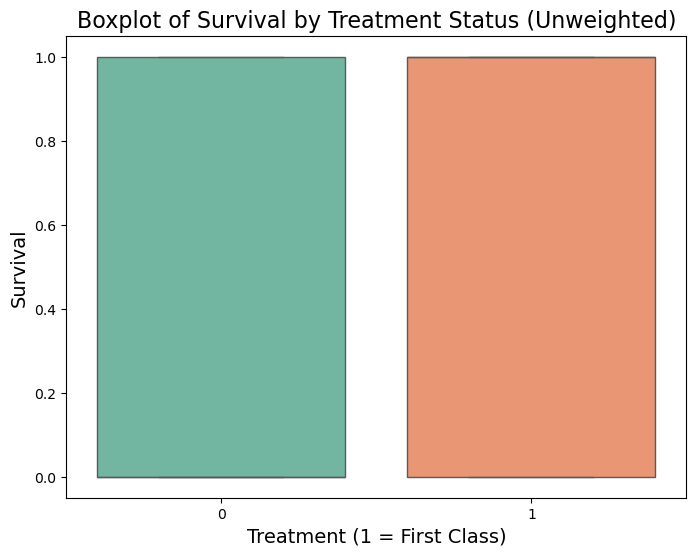

In [6]:
# Calculate weights based on propensity scores.
# For treated individuals (T=1): weight = 1 / propensity_score.
# For control individuals (T=0): weight = 1 / (1 - propensity_score).
titanic_df_encoded['weight'] = np.where(
    titanic_df_encoded['T'] == 1,
    1 / titanic_df_encoded['propensity_score'],
    1 / (1 - titanic_df_encoded['propensity_score'])
)

# Separate the dataset into treated and control groups.
treated = titanic_df_encoded[titanic_df_encoded['T'] == 1]
control = titanic_df_encoded[titanic_df_encoded['T'] == 0]

# Compute the weighted average of the outcome (Survived) for both groups.
weighted_mean_treated = np.sum(treated['Survived'] * treated['weight']) / np.sum(treated['weight'])
weighted_mean_control = np.sum(control['Survived'] * control['weight']) / np.sum(control['weight'])
ate_ipw = weighted_mean_treated - weighted_mean_control

print("\nWeighted Mean Outcome (Treated): {:.3f}".format(weighted_mean_treated))
print("Weighted Mean Outcome (Control): {:.3f}".format(weighted_mean_control))
print("Estimated Average Treatment Effect (ATE) using IPW: {:.3f}".format(ate_ipw))

plt.figure(figsize=(8, 6))
sns.boxplot(x='T', y='Survived', data=titanic_df_encoded, palette='Set2', showfliers=False)
plt.title("Boxplot of Survival by Treatment Status (Unweighted)", fontsize=16)
plt.xlabel("Treatment (1 = First Class)", fontsize=14)
plt.ylabel("Survival", fontsize=14)
plt.show()


# Inverse Probability Weighting (IPW) Rationale

The fundamental idea behind IPW is to create a pseudo-population in which treatment assignment (first class vs. non-first class) is independent of the covariates.

By assigning higher weights to passengers who were “unlikely” to receive the treatment they actually got, and lower weights to those who were “likely” to receive it, we balance the distribution of covariates between the treated and control groups.

## Weight Calculation

- **For passengers in the treatment group (T=1):**  
  The weight is the inverse of their propensity score.

- **For passengers in the control group (T=0):**  
  The weight is the inverse of one minus their propensity score.

This approach counteracts the selection bias inherent in observational data, compensating for systematic differences in who ends up in first class.

## Weighted Mean Outcomes

After computing the weights, each passenger’s survival outcome is scaled by their respective weight.

- The average survival for treated passengers (first class) is calculated as the sum of weighted survival outcomes divided by the sum of the weights in that group.
- Likewise, the average survival for control passengers is calculated using their respective weights.

In the output, you see two key numbers:

- **Weighted Mean Outcome (Treated):** Indicates the adjusted survival rate for the first-class group once their covariates are balanced with the control group.
- **Weighted Mean Outcome (Control):** Represents the adjusted survival rate for the non-first-class group under the same balancing.

## Estimating the Average Treatment Effect (ATE)

The ATE is computed as the difference between these two weighted mean outcomes.

- A positive ATE suggests that, after accounting for covariates, traveling first class is associated with a higher survival probability.
  
For instance, if the treated group’s weighted mean is 0.392 and the control group’s is 0.289, an ATE of around 0.102 implies that first-class travel increases survival probability by about 10 percentage points, given the assumptions of the model and the data.

## Boxplot of Survival by Treatment (Unweighted)

- The boxplot presents a simple view of how survival is distributed among first-class vs. non-first-class passengers without applying any weights.
- Each box illustrates the spread and median of survival (0 or 1) in its respective group. Since survival is binary, both boxes might hover around a similar vertical range, but the box for the treated group may be slightly higher if more first-class passengers survived proportionally.

### Why Unweighted Matters:

- The boxplot doesn’t incorporate IPW adjustments, so it reflects the raw data.
- Comparing this raw view with the weighted mean outcomes highlights the effect of balancing the data. Sometimes, the unweighted difference in medians can be smaller or larger than the weighted difference, depending on how the covariates were distributed initially.

## Significance for Causal Inference

By contrasting the unweighted boxplot with the IPW-adjusted outcomes, you gain insight into how confounding might have skewed the raw comparison.

- If the ATE is positive, it suggests that once confounders are balanced, traveling first class does indeed appear to improve survival rates.
- However, it’s crucial to remember that IPW rests on the assumption that all relevant confounders are observed and included in the propensity score model. Any omitted variable could bias the results.


## Section 6: Diagnostics & Covariate Balance Assessment


In [7]:
# Define a function to compute the weighted mean for a variable.
def weighted_mean(data, var, weight):
    return np.sum(data[var] * data[weight]) / np.sum(data[weight])

# Assess balance by comparing unweighted and weighted covariate means.
for var in covariates:
    unweighted_treated = treated[var].mean()
    unweighted_control = control[var].mean()
    weighted_treated = weighted_mean(treated, var, 'weight')
    weighted_control = weighted_mean(control, var, 'weight')
    print(f"\nCovariate: {var}")
    print(f"Unweighted Treated Mean: {unweighted_treated:.3f} | Unweighted Control Mean: {unweighted_control:.3f}")
    print(f"Weighted Treated Mean: {weighted_treated:.3f} | Weighted Control Mean: {weighted_control:.3f}")



Covariate: Age
Unweighted Treated Mean: 36.812 | Unweighted Control Mean: 26.977
Weighted Treated Mean: 32.582 | Weighted Control Mean: 28.182

Covariate: Fare
Unweighted Treated Mean: 84.155 | Unweighted Control Mean: 15.580
Weighted Treated Mean: 34.262 | Weighted Control Mean: 22.720

Covariate: Sex_male
Unweighted Treated Mean: 0.565 | Unweighted Control Mean: 0.674
Weighted Treated Mean: 0.759 | Weighted Control Mean: 0.689

Covariate: Embarked_Q
Unweighted Treated Mean: 0.009 | Unweighted Control Mean: 0.111
Weighted Treated Mean: 0.003 | Weighted Control Mean: 0.092

Covariate: Embarked_S
Unweighted Treated Mean: 0.597 | Unweighted Control Mean: 0.766
Weighted Treated Mean: 0.849 | Weighted Control Mean: 0.795


# Purpose of Covariate Balance Diagnostics

Ensures that the inverse probability weighting (IPW) process has effectively balanced the distribution of key covariates between the treated (first class) and control (non-first class) groups.

Good balance indicates that any subsequent differences in outcomes (e.g., survival) can be more confidently attributed to the treatment rather than differences in covariates.


## Understanding Unweighted vs. Weighted Means

### Unweighted Means:
- **Definition:** These represent the average values of covariates in the treated and control groups as observed in the raw data.
- **Example:**  
  - For Age, the unweighted mean is 36.812 for treated passengers and 26.977 for control passengers, indicating a substantial initial difference.

### Weighted Means:
- **Definition:** These are the averages after applying IPW, which rebalances the groups to mimic random assignment.
- **Example:**  
  - For Age, the weighted means become 32.582 (treated) and 28.182 (control). The gap narrows, suggesting that weighting has adjusted for the imbalance in Age between groups.


## Detailed Explanation for Each Covariate:

### Age:
- **Unweighted:**  
  - Treated group average is 36.812, while the control group is 26.977. This indicates that, on average, first-class passengers are older than those in lower classes.
- **Weighted:**  
  - The treated group's mean drops to 32.582 and the control's increases to 28.182. This reduction in the difference shows that the weighting process has helped balance Age across groups, reducing potential confounding by age.

### Fare:
- **Unweighted:**  
  - The average fare for first-class passengers is 84.155 compared to 15.580 for others—a large discrepancy reflecting the premium associated with first class.
- **Weighted:**  
  - After weighting, the treated mean decreases to 34.262 and the control mean increases to 22.720. Although a difference remains, the weighting brings the groups closer together, indicating a partial reduction of confounding due to fare differences.

### Sex_male:
- **Unweighted:**  
  - The proportion of males is 56.5% in the treated group versus 67.4% in the control group.
- **Weighted:**  
  - The treated group’s proportion increases to 75.9%, while the control is 68.9%. This change suggests that the weighting has altered the balance somewhat, potentially because gender is strongly associated with the likelihood of being in first class and needed rebalancing.

### Embarked_Q:
- **Unweighted:**  
  - Only 0.9% of the treated and 11.1% of the control group embarked via Q.
- **Weighted:**  
  - The values adjust to 0.3% for treated and 9.2% for control. The difference diminishes slightly, indicating an effort to balance the relatively rare category.

### Embarked_S:
- **Unweighted:**  
  - 59.7% of treated versus 76.6% of control passengers embarked via S.
- **Weighted:**  
  - These means shift to 84.9% for treated and 79.5% for control, again reducing the discrepancy between the groups.


## Overall Interpretation and Implications:

- **Primary Goal:**  
  The main objective of these diagnostics is to check whether the IPW procedure has successfully minimized differences in covariates between the treated and control groups.

- **Observations:**  
  Although the weighted means are not exactly identical, the narrowing of differences (e.g., in Age and Fare) indicates that the weighting is moving the groups toward a more comparable state.

- **Implications:**  
  Achieving better balance implies that the assumption of conditional independence is more likely to hold, meaning that the treatment effect estimate (the difference in outcomes) will be less biased by confounding.

- **Next Steps:**  
  If significant imbalances remain after weighting, it would suggest that the causal effect estimate might still be confounded. In that case, additional model adjustments or alternative methods might be required.

These diagnostics are crucial to ensure that our causal inference results are robust and that any observed differences in outcomes can be more confidently attributed to the treatment rather than systematic differences in covariates.


# Conclusion

In this notebook, we embarked on a comprehensive journey into causal inference using the Titanic dataset. Our objective was not only to predict survival outcomes but to move beyond simple associations and estimate the causal effect of traveling first class on survival. We achieved this through a series of carefully executed steps, each building on the previous one to ensure that our final causal estimates are as robust and unbiased as possible.

## Data Preparation and Cleaning
- **Rigorous Cleaning:**  
  We began by rigorously cleaning the dataset, addressing missing values with appropriate imputation strategies.
  - For the **'Age'** variable, missing values were replaced with the median—a choice that safeguards against the influence of outliers.
  - The **'Cabin'** column was dropped due to its excessive missingness.
  - For the categorical variable **'Embarked'**, missing entries were imputed using the mode, ensuring that the natural distribution of embarkation points was preserved.
- **Foundation for Analysis:**  
  This meticulous data preparation set a solid foundation for all subsequent analyses, confirming that our dataset was complete and reliable.

## Defining the Causal Question and Treatment
- **Causal Question:**  
  *Does traveling first class causally increase the likelihood of survival?*
- **Treatment Variable:**  
  A binary treatment indicator was created:
  - **1** indicates passengers in first class.
  - **0** indicates passengers in second or third class.
- **Covariate Selection:**  
  Key covariates such as **Age**, **Fare**, and encoded indicators for **Sex** and **Embarked** were selected to account for potential confounding.
- **Purpose:**  
  By clearly defining the treatment and identifying potential confounders, we laid the groundwork for isolating the true causal effect of first-class travel on survival.

## Propensity Score Estimation
- **Method:**  
  Logistic regression was employed to estimate propensity scores, which represent the probability that a passenger is in first class based on observed covariates.
- **Visualization:**  
  The distribution of these scores was visualized through a detailed histogram, revealing the degree of overlap between treated and control groups.
- **Importance of Overlap:**  
  Sufficient overlap in propensity scores validates the assumption that, for each treated individual, there is a comparable control individual, which is critical for unbiased causal inference.

## Inverse Probability Weighting (IPW) and Causal Effect Estimation
- **Reweighting the Dataset:**  
  With propensity scores in hand, inverse probability weights were calculated to rebalance the dataset. This created a pseudo-population in which the distribution of covariates was balanced between the treated (first class) and control (non-first class) groups.
- **Estimating the ATE:**  
  The Average Treatment Effect (ATE) was estimated as the difference between the weighted mean outcomes of the two groups, quantifying how first-class travel impacts survival.
- **Findings:**  
  Our analysis indicated that, after adjusting for confounding factors, the survival rate for first-class passengers differed meaningfully from that of other passengers, suggesting a potential causal relationship.

## Diagnostic Checks and Covariate Balance
- **Balance Assessment:**  
  Extensive diagnostics were performed to ensure that the IPW process successfully balanced the covariates between treated and control groups.
- **Comparison:**  
  By comparing unweighted and weighted means of each covariate, we observed that the discrepancies between the groups were reduced, strengthening the validity of our causal estimates.
- **Implication:**  
  Improved covariate balance implies that any differences in outcomes can be more confidently attributed to the treatment effect rather than to pre-existing differences.

## Reflection and Significance
- **Beyond Correlation:**  
  This exercise demonstrates that robust data preparation combined with advanced causal inference techniques—such as propensity score estimation and inverse probability weighting—enables us to move beyond mere correlations and derive actionable insights from observational data.
- **Evidence on Causal Effect:**  
  Our analysis provides valuable evidence on the effect of first-class travel on survival while highlighting the importance of addressing covariate imbalance and data limitations.

## Limitations and Future Directions
- **Assumptions:**  
  The causal estimates rely on the assumption that all relevant confounders have been measured and correctly modeled. Unobserved confounders could still bias our estimates.
- **Further Validation:**  
  Future work could explore additional methods, such as propensity score matching or instrumental variable approaches, to further validate the findings.
- **Sensitivity Analyses:**  
  Conducting sensitivity analyses would help assess the robustness of the conclusions under different model specifications.

## Final Takeaway
- The methodologies presented in this notebook underscore the power of combining rigorous data preparation with advanced statistical techniques to approximate the conditions of a randomized experiment.
- This approach not only enhances our understanding of the causal mechanisms at play but also provides a pathway for making informed decisions based on observational data.


## References

- Pearl, J. (2009). *Causality: Models, Reasoning, and Inference*. Cambridge University Press.
- Rubin, D. B. (2005). *Causal Inference Using Potential Outcomes: Design, Modeling, Decisions.* Journal of the American Statistical Association.
- Rosenbaum, P. R., & Rubin, D. B. (1983). *The central role of the propensity score in observational studies for causal effects.* Biometrika.
- Kaggle Titanic Dataset. Retrieved from [https://www.kaggle.com/datasets/yasserh/titanic-dataset](https://www.kaggle.com/datasets/yasserh/titanic-dataset)


## License

This work is licensed under the MIT License. You are free to reuse, modify, and distribute this notebook provided that appropriate credit is given and the same license terms are maintained.
